In [1]:
import mlflow
import numpy as np, tempfile, boto3, os, pickle, xarray as xr
from matplotlib import pyplot as plt
import scienceplots

plt.style.use(['science', "no-latex"])
from tqdm import tqdm
from jax import vmap
from mlflow.entities import ViewType
mlflow.set_tracking_uri("https://continuum.ergodic.io/experiments/")

In [2]:
exp = mlflow.get_experiment_by_name("opt-64lines")
# cutoff_exp = mlflow.get_experiment_by_name("zerolines-64lines")
num_colors_exp = mlflow.get_experiment_by_name("num-color-scan")
random_phase_xp = mlflow.get_experiment_by_name("randomphaser-64lines")
# exp = mlflow.get_experiment_by_name("opt-64lines-ensembles")

In [3]:
# filter runs with "temperature" in the mlflow run name
runs = mlflow.search_runs(experiment_names=[exp.name], filter_string="attribute.run_name LIKE '%temperature%'", max_results=1000)
# cutoff_runs = mlflow.search_runs(experiment_names=[cutoff_exp.name], filter_string="attribute.run_name LIKE '%temperature%'")
# filter all values where metrics.loss is not yet defined
num_colors_runs = mlflow.search_runs(experiment_names=[num_colors_exp.name], filter_string="attributes.run_name LIKE '%temperature%'", max_results=10000)
random_phase_runs = mlflow.search_runs(experiment_names=[random_phase_xp.name], filter_string="attributes.run_name LIKE '%temperature%'", max_results=10000)
# these_runs = mlflow.search_runs(experiment_names=[num_colors_exp.name], filter_string="tags.ensemble_status LIKE 'incomplete'", max_results=1000)

In [27]:
from itertools import product
temperatures = np.linspace(2000, 4000, 5)
gradient_scale_lengths = np.linspace(200, 600, 4)
intensities = np.linspace(1e14, 1e15, 4)
num_colors = np.linspace(16, 128, 15)

all_hps = list(product(temperatures, gradient_scale_lengths, intensities, num_colors))

run_names = {f"temperature={tt:.1f}-gsl={gsl:.1f}-intensity={intensity:.2e}-nc={int(nc)}" for tt, gsl, intensity, nc in all_hps}
remaining_runs = set(run_names) - set(num_colors_runs["tags.mlflow.runName"].values)

In [30]:
rem_hps = []
for run_name in remaining_runs:
    temp, gsl, intensity, nc = [float(val.split("=")[-1]) for val in run_name.split("-")]
    rem_hps.append((temp, gsl, intensity, int(nc)))

In [32]:
# write the remaining hyperparameters to a file
with open("remaining_hyperparameters.txt", "w") as f:
    for temp, gsl, intensity, nc in rem_hps:
        f.write(f"{temp:.1f} {gsl:.1f} {intensity:.2e} {nc}\n")

In [25]:

marked_to_delete = []
run_names_to_delete = []
mlflow.set_experiment("num-color-scan")
for idx, par_run in tqdm(num_colors_runs.iterrows()):
    par_run_id = par_run["run_id"]
    all_child_runs = mlflow.search_runs(experiment_names=[num_colors_exp.name], filter_string=f"tags.mlflow.parentRunId = '{par_run_id}'", max_results=8)
    
    if "metrics.loss" not in all_child_runs.columns:
        marked_to_delete += [par_run_id] + list(all_child_runs["run_id"])
        run_names_to_delete.append(par_run["tags.mlflow.runName"])
        with mlflow.start_run(run_id=par_run_id) as run:
            mlflow.set_tag("ensemble_status", "incomplete")
    else:
        # check each run
        metrics_found = True
        losses = []
        for idx, _run in all_child_runs.iterrows():
            # print(_run["metrics.run_time"])
            if _run["metrics.run_time"] != _run["metrics.run_time"]:
                metrics_found = False
            else:
                losses.append(_run["metrics.loss"])

        if not metrics_found:
            marked_to_delete += [par_run_id] + list(all_child_runs["run_id"])
            run_names_to_delete.append(par_run["tags.mlflow.runName"])
            with mlflow.start_run(run_id=par_run_id) as run:
                mlflow.set_tag("ensemble_status", "incomplete")
        else:
            loss = np.mean(losses)
            mlflow.log_metric("loss", loss, run_id=par_run_id)
            with mlflow.start_run(run_id=par_run_id) as run:
                mlflow.set_tag("ensemble_status", "complete")
    
    


812it [06:48,  2.26it/s]/pscratch/sd/a/archis/venvs/ml-for-lpi/lib/python3.11/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
824it [06:54,  2.28it/s]/pscratch/sd/a/archis/venvs/ml-for-lpi/lib/python3.11/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
868it [07:14,  2.33it/s]/pscratch/sd/a/archis/venvs/ml-for-lpi/lib/python3.11/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
912it [07:34,  2.33it/s]/pscratch/sd/a/archis/venvs/ml-for-lpi/lib/python3.11/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
945it [07:48,  2.24it/s]/pscratch/sd/a/archis/venvs/ml-for-lpi/lib/python3.11/si

In [14]:
num_colors_runs["params.density.gradient scale length"].unique()

array(['466.7 um', '600.0 um', '200.0 um', '333.3 um',
       '333.33333333333337 um', '466.6666666666667 um'], dtype=object)

In [100]:
tt = 4000
gsl = 333.3
gsl2 = 333.33333333333337
intensity = 7e14

these_runs = (num_colors_runs["params.units.reference electron temperature"] == f"{tt:.1f} eV") & (num_colors_runs["params.density.gradient scale length"] == f"{gsl} um") & (num_colors_runs["params.units.laser intensity"] == f"{intensity:.1f} W/cm^2")
these_runs2 = (num_colors_runs["params.units.reference electron temperature"] == f"{tt:.1f} eV") & (num_colors_runs["params.density.gradient scale length"] == f"{gsl2} um") & (num_colors_runs["params.units.laser intensity"] == f"{intensity:.1f} W/cm^2")

uniform_runs = num_colors_runs[these_runs | these_runs2]


these_runs = (runs["params.units.reference electron temperature"] == f"{tt:.1f} eV") & (runs["params.density.gradient scale length"] == f"{gsl} um") & (runs["params.units.laser intensity"] == f"{intensity:.1f} W/cm^2")
these_runs2 = (runs["params.units.reference electron temperature"] == f"{tt:.1f} eV") & (runs["params.density.gradient scale length"] == f"{gsl2} um") & (runs["params.units.laser intensity"] == f"{intensity:.1f} W/cm^2")
these_runs = these_runs | these_runs2
opt_run = runs[these_runs]

uniform_run = uniform_runs[uniform_runs["params.drivers.E0.num_colors"] == "64"]
uniform_run2 = uniform_runs[uniform_runs["params.drivers.E0.num_colors"] == "4"]

these_runs = (random_phase_runs["params.units.reference electron temperature"] == f"{tt:.1f} eV") & (random_phase_runs["params.density.gradient scale length"] == f"{gsl} um") & (random_phase_runs["params.units.laser intensity"] == f"{intensity:.1f} W/cm^2")
these_runs2 = (random_phase_runs["params.units.reference electron temperature"] == f"{tt:.1f} eV") & (random_phase_runs["params.density.gradient scale length"] == f"{gsl2} um") & (random_phase_runs["params.units.laser intensity"] == f"{intensity:.1f} W/cm^2")
these_runs = these_runs | these_runs2
random_phase_run = random_phase_runs[these_runs]


print(len(uniform_runs), len(opt_run), len(random_phase_run))

26 1 1


In [55]:
opt_loss = xr.open_dataarray("../results/loss_values.nc")


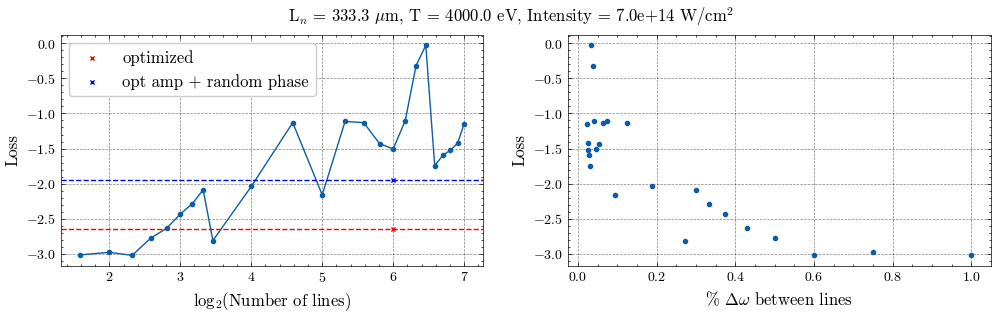

In [73]:

num_colors = uniform_runs["params.drivers.E0.num_colors"].astype(int)
losses = uniform_runs["metrics.loss"].values
losses = losses[np.argsort(num_colors)]
num_colors.values.sort()

num_colors = num_colors[2:]
losses = losses[2:]
random_phase_val = random_phase_run["metrics.loss"].values
opt_loss_val = opt_loss.loc[{"temperature": tt, "gsl": gsl2, "intensity": intensity}]

fig, ax = plt.subplots(1, 2, figsize=(12, 3))

plt.style.use(['science', "no-latex", "grid", "scatter"])

ax[0].plot(np.log2(num_colors), losses, "-o")
# ax[0].grid()
ax[0].set_xlabel(r"log$_2$(Number of lines)", fontsize=12)
ax[0].scatter(6, opt_loss_val, color="red", marker="x", label="optimized")
ax[0].scatter(6, random_phase_val, color="blue", marker="x", label="opt amp + random phase")
ax[0].axhline(opt_loss_val, color="red", linestyle="--")
ax[0].axhline(random_phase_val, color="blue", linestyle="--")
# ax[0].axhline(opt_loss_val, color="red", linestyle="--", label="optimized result")
ax[0].set_ylabel("Loss", fontsize=12)
ax[0].legend(fontsize=12)
ax[1].plot(3.0/num_colors, losses, "o")
# ax[1].grid()
ax[1].set_xlabel(r"% $\Delta \omega$ between lines", fontsize=12)
ax[1].set_ylabel("Loss", fontsize=12)
fig.suptitle(f"L$_n$ = {gsl:.1f} $\mu$m, T = {tt:.1f} eV, Intensity = {intensity:.1e} W/cm$^2$", fontsize=12)
fig.savefig("num_colors_scan.pdf", bbox_inches="tight")

In [74]:
opt_run['run_id'].iloc[0]

'904acee7bf16458989e023030e644f1f'

In [106]:
u_run = mlflow.search_runs(experiment_names=[num_colors_exp.name], filter_string=f"tags.mlflow.parentRunId = '{uniform_run['run_id'].iloc[0]}'", max_results=1)
u_run2 = mlflow.search_runs(experiment_names=[num_colors_exp.name], filter_string=f"tags.mlflow.parentRunId = '{uniform_run2['run_id'].iloc[0]}'", max_results=1)
o_run = mlflow.search_runs(experiment_names=[exp.name], filter_string=f"tags.mlflow.parentRunId = '{opt_run['run_id'].iloc[0]}'", max_results=20)
r_run = mlflow.search_runs(experiment_names=[random_phase_xp.name], filter_string=f"tags.mlflow.parentRunId = '{random_phase_run['run_id'].iloc[0]}'", max_results=1)


In [76]:
u_run["run_id"], o_run["run_id"], o_run["tags.mlflow.runName"]

(0    05782fa9ea594c08b740b94468135f89
 Name: run_id, dtype: object,
 0    e7f1475e60504f54b0a0e7e09f391f72
 1    84881415efd64bd8b1674da7ce577a5e
 2    aba32c98753942cf99d8c55cb28314ca
 3    6bea628108794b89a1a2dfa747601b95
 4    b605aa1d2ecd49719d761d82b80ac1ee
 5    4765add36acd49e38fa79c572656d5cc
 6    b71c7e9625a0409da38cc5484601ef0d
 7    03d25bdb61d54f1c80b90168f9450570
 8    00573dfa53754a32a49224c3757e5bf9
 Name: run_id, dtype: object,
 0    epoch-8
 1    epoch-7
 2    epoch-6
 3    epoch-5
 4    epoch-4
 5    epoch-3
 6    epoch-2
 7    epoch-1
 8    epoch-0
 Name: tags.mlflow.runName, dtype: object)

In [107]:
# download file from s3
s3 = boto3.client('s3')
bucket_name = "public-ergodic-continuum"

run_id = u_run["run_id"].iloc[0]
file_path = f"188326/{run_id}/artifacts/binary/series.xr"
s3.download_file(bucket_name, file_path, "uniform-series.xr")

run_id = u_run2["run_id"].iloc[0]
file_path = f"188326/{run_id}/artifacts/binary/series.xr"
s3.download_file(bucket_name, file_path, "uniform-series2.xr")

run_id = o_run["run_id"].iloc[0]
file_path = f"181417/{run_id}/artifacts/binary/series.xr"
s3.download_file(bucket_name, file_path, "optimized-series.xr")

run_id = r_run["run_id"].iloc[0]
file_path = f"{random_phase_xp.experiment_id}/{run_id}/artifacts/binary/series.xr"
s3.download_file(bucket_name, file_path, "random-phase-series.xr")


# load the series
uniform_series = xr.open_dataarray("uniform-series.xr")
optimized_series = xr.open_dataarray("optimized-series.xr")
uniform_series2 = xr.open_dataarray("uniform-series2.xr")
random_phase_series = xr.open_dataarray("random-phase-series.xr")


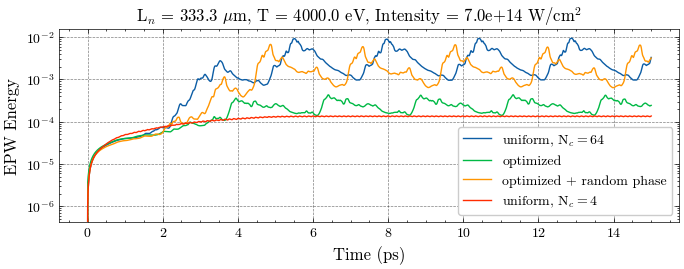

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))
plt.style.use(['science', "no-latex", "grid"])
uniform_series.plot(label="uniform, N$_c = 64$", ax=ax)
optimized_series.plot(label="optimized", ax=ax)
random_phase_series.plot(label="optimized + random phase", ax=ax)
uniform_series2.plot(label="uniform, N$_c = 4$", ax=ax)
ax.set_yscale("log")
ax.legend()
ax.set_xlabel("Time (ps)", fontsize=12)
ax.set_ylabel("EPW Energy", fontsize=12)
fig.suptitle(f"L$_n$ = {gsl:.1f} $\mu$m, T = {tt:.1f} eV, Intensity = {intensity:.1e} W/cm$^2$", fontsize=12)
fig.savefig("uniform_vs_optimized.pdf", bbox_inches="tight")